# Attempting To Do Some Sort Of Ray Tracing

### Very Basic First Attempt
- In 2D
- Starting with 5 rays coming in through air 
- Hitting water 
- Measured at discrete points

In [8]:
%pylab ipympl
from scipy import interpolate
from scipy import misc

Populating the interactive namespace from numpy and matplotlib


In [34]:
def lineslope(x,m,b):
    '''
    Each ray follows over a locally straight area.
    '''
    return m*x + b

In [2]:
def lineangle(x,theta):
    '''
    Each ray follows over a locally straight area.
    '''
    return x*tan(theta)

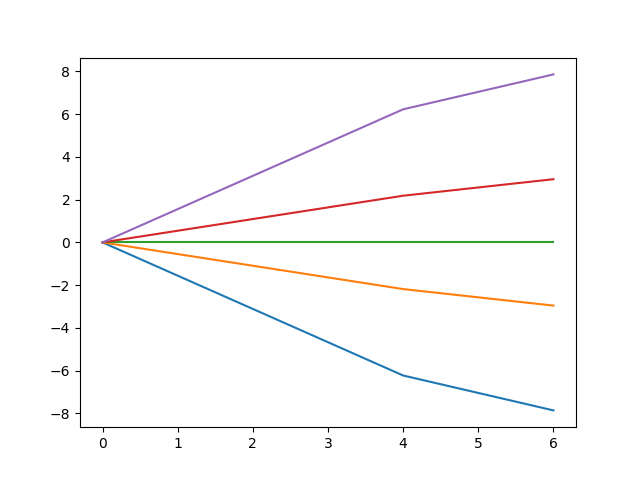

In [58]:
lines = {0:{'angle':-1},1:{'angle':-0.5},2:{'angle':0},3:{'angle':0.5},4:{'angle':1}}
xtries = linspace(0,6,7)
ycorr = [] # y points that correspond to xtries

air = (0,4)
water = (4,6)
waterind = 1.33

for n in lines.keys():
    ycorr.append([])
    switchpoints = [(0,0)]
    for x in xtries:
        if x == air[1]: 
            y = lineangle(x-switchpoints[-1][0],lines[n]['angle']) + switchpoints[-1][1]
            lines[n]['angle'] = arcsin(sin(lines[n]['angle'])/waterind)
            switchpoints.append((x,y))
        else:
            y = lineangle(x-switchpoints[-1][0],lines[n]['angle']) + switchpoints[-1][1]
        ycorr[n].append(y)
        # print(switchpoints)

ifig=1;close(ifig);figure(ifig)
for n in range(len(ycorr)):
    plot(xtries,ycorr[n])

# xplt = linspace(0,5,6)
# ifig=1;close(ifig);plot(ifig)
# for n in lines.keys():
#     plot(xplt,lineangle(xplt,lines[n]['angle']),label='line ' + str(n+1))
# legend()

### Second Attempt 
- Using `gradient`
- Still in 2D
- Still only 5 lines, but can easily extend to more now
- Air -> Water -> Copper
- More wiggle room in terms of point having to be exactly on the border

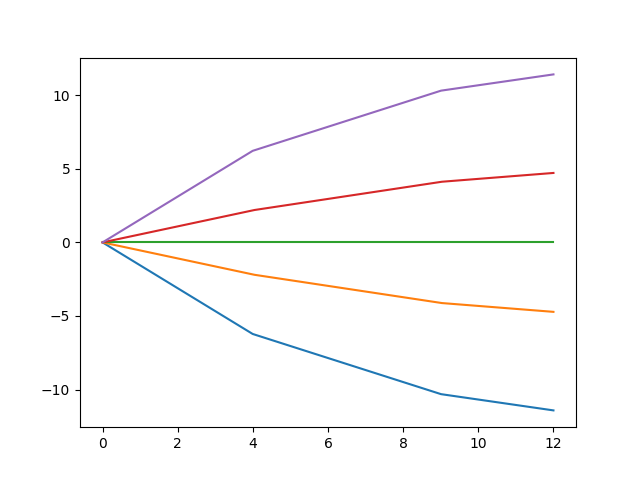

In [39]:
lines = [{'angle':-1},{'angle':-0.5},{'angle':0},{'angle':0.5},{'angle':1}]
# angles must be in (-pi/2,pi/2)
xtries = linspace(0,6,7) # ARBITRARY DEF
ycorr = [] # y points that correspond to xtries
matinds = [(0,1)] # indices of the materials in the form (x value, index)
matpoints = 128
ntries = 1004
eps = 1.e-5

airspace = (0,4)
waterspace = (4,9)
copperspace = (9,12)
airind = 1
waterind = 1.33
copperind = 2.43
currind = airind

materials = {'air':{'space':airspace,'index':airind},'water':{'space':waterspace,'index':waterind},'copper':{'space':copperspace,'index':copperind}}

for material in materials.keys():
    matinds += list(array((linspace(materials[material]['space'][0],materials[material]['space'][1],matpoints),materials[material]['index']*ones(matpoints))).T)[1:]
matinds = array(matinds)
gradinds = array((matinds.T[0],gradient(matinds.T[1]))).T

xtries = linspace(materials['air']['space'][0],materials['copper']['space'][1],ntries) # another arbitrary definition

eps = max(min(abs(gradinds[where(gradinds.T[1]!=0)[0]].T[0][0] - xtries)),min(abs(gradinds[where(gradinds.T[1]!=0)[0]].T[0][2] - xtries)))
# this would have to be modified for real data
# I am also picking out the specific gradient indices I want which is not applicable

for n in range(len(lines)):
    ycorr.append([])
    switchpoints = [(0,0)]
    currind = airind
    for x in xtries:
        if abs(x-gradinds.T[0][where(gradinds.T[1]!=0)[0]].T[0]) <= eps or abs(x-gradinds.T[0][where(gradinds.T[1]!=0)[0]].T[2]) <= eps: 
            # ^ THIS IS ONCE AGAIN SPECIFIC
            y = lineangle(x-switchpoints[-1][0],lines[n]['angle']) + switchpoints[-1][1]
            nextind = matinds.T[1][where(abs(gradinds.T[0]-x) == min(abs(gradinds.T[0]-x)))[0][0]+1] # assuming the proper index is the next one
            lines[n]['angle'] = arcsin(currind*sin(lines[n]['angle'])/nextind)
            currind =  nextind
            switchpoints.append((x,y))
        else:
            y = lineangle(x-switchpoints[-1][0],lines[n]['angle']) + switchpoints[-1][1]
        y = float64(y) # should fix the actual problem and not just mask it here
        ycorr[n].append(y)

ifig=2;close(ifig);figure(ifig)
for n in range(len(ycorr)):
    plot(xtries,ycorr[n])
    

### Optimizing & Organzing
- Trying to improve second algorithm before extending to 3D 
- Making code more clear and readable 

In [44]:
def ray_tracing_2(xtries,gradinds,matinds,airind,angle):
    '''
    This is still specific, will need to be adjusted.
    Error because doesn't actually take eps as an argument, just uses from other stuff.
    '''
    ypoints = []
    switchpoints = [(0,0)]
    currind = airind
    
    for x in xtries:
        if abs(x-gradinds.T[0][where(gradinds.T[1]!=0)[0]].T[0]) <= eps or abs(x-gradinds.T[0][where(gradinds.T[1]!=0)[0]].T[2]) <= eps: 
            # ^ THIS IS ONCE AGAIN SPECIFIC
            y = lineangle(x-switchpoints[-1][0],angle) + switchpoints[-1][1]
            nextind = matinds.T[1][where(abs(gradinds.T[0]-x) == min(abs(gradinds.T[0]-x)))[0][0]+1] # assuming the proper index is the next one
            angle = arcsin(currind*sin(angle)/nextind)
            currind =  nextind
            switchpoints.append((x,y))
        else:
            y = lineangle(x-switchpoints[-1][0],angle) + switchpoints[-1][1]
        y = float64(y) # should fix the actual problem and not just mask it here
        ypoints.append(y)

    return ypoints

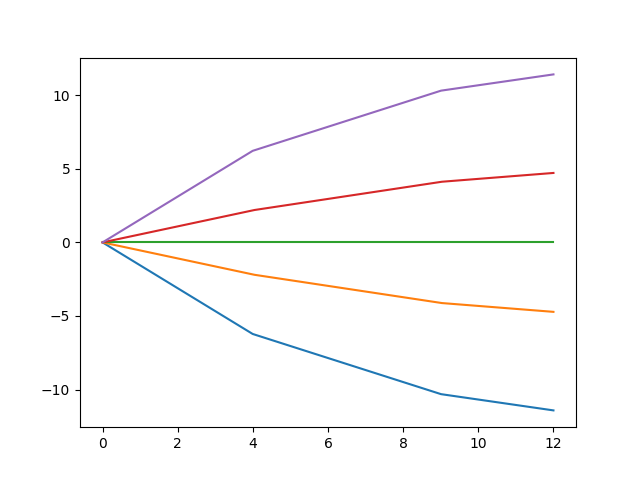

In [45]:
'''
Variables you can change.
'''
lines = [{'angle':-1},{'angle':-0.5},{'angle':0},{'angle':0.5},{'angle':1}]
# angles must be in (-pi/2,pi/2)
matpoints = 128
ntries = 1004


'''
This is the set-up of the indices of materials: this is equivalent to what would be given in a CT scan or something.
'''
airspace = (0,4)
waterspace = (4,9)
copperspace = (9,12)
airind = 1
waterind = 1.33
copperind = 2.43

matinds = [(0,1)] # indices of the materials in the form (x value, index)

materials = {'air':{'space':airspace,'index':airind},'water':{'space':waterspace,'index':waterind},'copper':{'space':copperspace,'index':copperind}}

for material in materials.keys():
    matinds += list(array((linspace(materials[material]['space'][0],materials[material]['space'][1],matpoints),materials[material]['index']*ones(matpoints))).T)[1:]
matinds = array(matinds)


'''
Final set-up.
'''
ycorr = [] # y points that correspond to xtries

gradinds = array((matinds.T[0],gradient(matinds.T[1]))).T

xtries = linspace(materials['air']['space'][0],materials['copper']['space'][1],ntries) # another arbitrary definition

eps = max(min(abs(gradinds[where(gradinds.T[1]!=0)[0]].T[0][0] - xtries)),min(abs(gradinds[where(gradinds.T[1]!=0)[0]].T[0][2] - xtries)))
# this would have to be modified for real data
# I am also picking out the specific gradient indices I want which is not applicable
# Once I have real data I will modify this


'''
Actual ray-tracing.
'''
for n in range(len(lines)):
    ycorr.append(ray_tracing_2(xtries,gradinds,matinds,airind,lines[n]['angle']))


'''
Plotting.
'''
ifig=3;close(ifig);figure(ifig)
for n in range(len(ycorr)):
    plot(xtries,ycorr[n])



### Extending to 3D
- Taking previous algorithm and extending to 3D

In [5]:
l1 = [1,2,3,4]
l2 = [4,5,6]
for a,b in zip(l1,l2):
    print(a,b)

1 4
2 5
3 6


In [9]:
misc.derivative?

Signature: misc.derivative(func, x0, dx=1.0, n=1, args=(), order=3)
Docstring:
Find the nth derivative of a function at a point.

Given a function, use a central difference formula with spacing `dx` to
compute the nth derivative at `x0`.

Parameters
----------
func : function
    Input function.
x0 : float
    The point at which the nth derivative is found.
dx : float, optional
    Spacing.
n : int, optional
    Order of the derivative. Default is 1.
args : tuple, optional
    Arguments
order : int, optional
    Number of points to use, must be odd.

Notes
-----
Decreasing the step size too small can result in round-off error.

Examples
--------
>>> from scipy.misc import derivative
>>> def f(x):
...     return x**3 + x**2
>>> derivative(f, 1.0, dx=1e-6)
4.9999999999217337
File:      /usr/local/lib/python3.6/dist-packages/scipy/misc/common.py
Type:      function


In [6]:
def ray_tracing_3(measure_pts,angle,indfunc):
    '''
    This is still specific, will need to be adjusted. Works for 3D.
    measure_pts = (xtries,ytries)
    '''
    zpoints = []
    switchpoints = [(0,0)]
    xtries,ytries = measure_pts
    eps = 1.e-2 # arbitrary -> should change to a meaningful value like in previous
    grad = misc.derivative(indfunc,dx=0.001) # dx also arbitrary, could change to half the distance between points or something
    
    for x,y in zip(xtries,ytries):
        mag = sqrt(x**2+y**2) 
        if abs(grad[where(grad!=0)[0]].any()-sq) <= eps: # WRONG but need to find correct way to do
            # ^ THIS IS ONCE AGAIN SPECIFIC
            y = lineangle(x-switchpoints[-1][0],angle) + switchpoints[-1][1]
            nextind = matinds.T[1][where(abs(gradinds.T[0]-x) == min(abs(gradinds.T[0]-x)))[0][0]+1] # assuming the proper index is the next one
            angle = arcsin(currind*sin(angle)/nextind)
            currind =  nextind
            switchpoints.append((x,y))
        else:
            y = lineangle(x-switchpoints[-1][0],angle) + switchpoints[-1][1]
        y = float64(y) # should fix the actual problem and not just mask it here
        ypoints.append(y)

    return zpoints


In [3]:
'''
Variables you can change.
'''
anglerange = 1
lines = [{'anglex':n/2,'angley':i/2} for i in range(-2*anglerange,2*anglerange+1) for n in range(-2*anglerange,2*anglerange+1)]
# angles must be in (-pi/2,pi/2)
matpoints = 128
ntries = 100


'''
This is the set-up of the indices of materials: this is equivalent to what would be given in a CT scan or something.
'''
airspace = (0,4)
waterspace = (4,9)
copperspace = (9,12)
airind = 1
waterind = 1.33
copperind = 2.43

matinds = [(0,1)] # indices of the materials in the form (x value, index)

materials = {'air':{'space':airspace,'index':airind},'water':{'space':waterspace,'index':waterind},'copper':{'space':copperspace,'index':copperind}}

for material in materials.keys():
    matinds += list(array((linspace(materials[material]['space'][0],materials[material]['space'][1],matpoints),materials[material]['index']*ones(matpoints))).T)[1:]
matinds = array(matinds)
matfunc = interpolate.interp1d(matinds.T[0],matinds.T[1],kind='next',fill_value='extrapolate')
# There is probably a much better way to do this but it's just settting up data so it's fine for now
# idk if I'd use interpolation on an actual CT but could perhaps be the move?

# This is all unnecessary
# matfunc = interpolate.interp1d(matinds.T[0],matinds.T[1],kind='next',fill_value='extrapolate')
# matindsx, matindsy = meshgrid(matinds.T[0],matinds.T[0])
# z = matfunc(sqrt(matindsx**2 + matindsy**2))
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from matplotlib import cm
# ifig=8;close(ifig);fig = plt.figure(ifig)
# ax = Axes3D(fig)
# ax.plot_surface(matindsx, matindsy,z, rstride=1, cstride=1, cmap=cm.spring)
# plt.show()


'''
Final set-up.
'''
ycorr = [] # y points that correspond to xtries

gradinds = array((matinds.T[0],gradient(matinds.T[1]))).T

xtries = linspace(materials['air']['space'][0],materials['copper']['space'][1],ntries) # another arbitrary definition

eps = max(min(abs(gradinds[where(gradinds.T[1]!=0)[0]].T[0][0] - xtries)),min(abs(gradinds[where(gradinds.T[1]!=0)[0]].T[0][2] - xtries)))
# this would have to be modified for real data
# I am also picking out the specific gradient indices I want which is not applicable
# Once I have real data I will modify this


'''
Actual ray-tracing.
'''
# for this I'm assuming that the material changes are radial 
for n in range(len(lines)):
    ycorr.append(ray_tracing_2(xtries,gradinds,matinds,airind,lines[n]['angle']))


'''
Plotting.
'''
ifig=3;close(ifig);figure(ifig)
for n in range(len(ycorr)):
    plot(xtries,ycorr[n])



NameError: name 'ray_tracing_2' is not defined

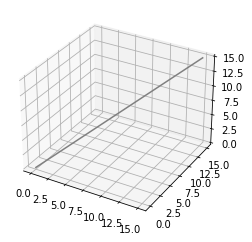

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = zline
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')